In [7]:
import pandas as pd
import sys
import os
import importlib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Configurar el path para poder importar tools
# El notebook está en ENTREGABLES/lorenn/, necesitamos subir un nivel a ENTREGABLES/
current_dir = os.getcwd()
# Si estamos en lorenn/, subir un nivel
if current_dir.endswith('lorenn'):
    entregables_dir = os.path.dirname(current_dir)
else:
    # Si no, buscar el directorio ENTREGABLES en el path actual
    entregables_dir = current_dir
    while not os.path.exists(os.path.join(entregables_dir, 'tools.py')):
        parent = os.path.dirname(entregables_dir)
        if parent == entregables_dir:  # Llegamos a la raíz
            break
        entregables_dir = parent

if os.path.exists(os.path.join(entregables_dir, 'tools.py')):
    if entregables_dir not in sys.path:
        sys.path.insert(0, entregables_dir)
    print(f"✅ Path configurado: {entregables_dir}")
else:
    print("⚠️ No se encontró el archivo tools.py. Verifica la estructura del proyecto.")

# Importar y recargar el módulo tools para asegurar que tenemos la versión más reciente
import tools
importlib.reload(tools)  # Recargar el módulo para obtener los cambios más recientes
from tools import (
    seleccionar_variables, 
    plot_costo_interactivo, 
    evaluate_model_with_thresholds, 
    evaluate_model,
    optimizar_threshold_costo_cv,
    optimizar_threshold_f1_cv
)

print("✅ Módulo tools recargado e importado correctamente")


✅ Path configurado: c:\Users\marca\OneDrive\AUSTRAL\2do año\2do cuat\TRP II\mercado-libre-fraude-2025\ENTREGABLES
✅ Módulo tools recargado e importado correctamente


In [8]:
df = pd.read_csv("../../DATA/processed/fraud_dataset_processed.csv")

df = seleccionar_variables(
    df,
    categoria_encoding=True, 
    pais_encoding=True,
    o_dummies=True,
    producto_nombre_encoding=True,
    fecha_encoding=3,
    usar_imputadas=True,
    remove_r = True,
    remove_d=True,
    remove_score=True
    )


Columnas reemplazadas por versiones imputadas: b, c, f, l, m, q


In [9]:
# ============================================================================
# PIPELINE COMPLETO DEL MODELO
# ============================================================================
# 1. Preparar datos
# 2. Entrenar modelos (uno con CV para optimizar thresholds, otro con todos los datos)
# 3. Optimizar thresholds (costo y F1) con CV
# 4. Evaluar modelo con ambos thresholds
# ============================================================================

# Preparar variables predictoras y target
X = df.drop(columns=['fraude'])
y = df['fraude']

# Split en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("=" * 80)
print("PASO 1: ENTRENAR MODELOS")
print("=" * 80)

# Configurar SVM con kernel RBF
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

# Usar SVC con kernel RBF y probability=True para obtener predict_proba
svm_cv = SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True, max_iter=200)
svm_final = SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True, max_iter=200)

# Configurar Cross-Validation (5 folds estratificados)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n✅ Modelos configurados:")
print(f"   - svm_cv: Para optimización de thresholds con CV")
print(f"   - svm_final: Para evaluación final con todos los datos de entrenamiento")

# Entrenar modelo final con todos los datos de entrenamiento (para evaluación)
print(f"\n🎯 Entrenando modelo final con todos los datos de entrenamiento...")
svm_final.fit(X_train, y_train)

# Predicciones en el conjunto de test
y_proba_test = svm_final.predict_proba(X_test)[:, 1]

print(f"\n✅ Modelo final entrenado")
print(f"   - Probabilidades en test: {len(y_proba_test)} muestras")


PASO 1: ENTRENAR MODELOS

✅ Modelos configurados:
   - svm_cv: Para optimización de thresholds con CV
   - svm_final: Para evaluación final con todos los datos de entrenamiento

🎯 Entrenando modelo final con todos los datos de entrenamiento...

✅ Modelo final entrenado
   - Probabilidades en test: 50000 muestras


In [10]:
# ============================================================================
# PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION
# ============================================================================

print("=" * 80)
print("PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION")
print("=" * 80)

# Parámetros de costo
costo_fp = 5.0
costo_fn = 100.0

# Calcular probabilidades de CV una sola vez (para evitar recalcular los folds)
print("\n📊 Calculando probabilidades con Cross-Validation...")
from sklearn.model_selection import cross_val_predict
y_proba_cv = cross_val_predict(svm_cv, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
print(f"✅ Probabilidades de CV calculadas: {len(y_proba_cv)} muestras")

# Optimizar threshold por costo usando CV
print("\n🔍 Optimizando threshold por función de costo...")
resultado_costo = optimizar_threshold_costo_cv(
    model=svm_cv,
    X=X_train,
    y=y_train,
    cv=cv,
    costo_fp=costo_fp,
    costo_fn=costo_fn,
    model_name="SVM RBF",
    y_proba_cv=y_proba_cv  # Reutilizar las probabilidades ya calculadas
)

threshold_optimo_costo = resultado_costo['threshold_optimo']
costo_minimo = resultado_costo['costo_minimo']

# Optimizar threshold por F1 Score usando CV
print("\n🔍 Optimizando threshold por F1 Score...")
resultado_f1 = optimizar_threshold_f1_cv(
    model=svm_cv,
    X=X_train,
    y=y_train,
    cv=cv,
    model_name="SVM RBF",
    y_proba_cv=y_proba_cv  # Reutilizar las probabilidades ya calculadas
)

threshold_optimo_f1 = resultado_f1['threshold_optimo']
f1_maximo = resultado_f1['f1_maximo']

print("\n" + "=" * 80)
print("RESUMEN DE THRESHOLDS ÓPTIMOS:")
print("=" * 80)
print(f"📌 Threshold óptimo (Costo): {threshold_optimo_costo:.4f}")
print(f"   Costo mínimo: {costo_minimo:.2f} por 1000 registros")
print(f"\n📌 Threshold óptimo (F1 Score): {threshold_optimo_f1:.4f}")
print(f"   F1 Score máximo: {f1_maximo:.4f}")


PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION

📊 Calculando probabilidades con Cross-Validation...
✅ Probabilidades de CV calculadas: 200000 muestras

🔍 Optimizando threshold por función de costo...

🎯 OPTIMIZACIÓN DE THRESHOLD POR COSTO (CV):
   Threshold óptimo: 0.0183
   Costo mínimo por 1000 registros: 2875.62
   FP ajustado: 7745
   FN ajustado: 5364

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0573
   Robustez: Muy robusto ✅
   Costo medio por fold: 2875.62 ± 164.73

🔍 Optimizando threshold por F1 Score...

🎯 OPTIMIZACIÓN DE THRESHOLD POR F1 SCORE (CV):
   Threshold óptimo: 0.0174
   F1 Score máximo: 0.0888
   Precision: 0.0643
   Recall: 0.1433

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.4939
   Robustez: Poco robusto ⚠️
   F1 Score medio por fold: 0.0729 ± 0.0360

RESUMEN DE THRESHOLDS ÓPTIMOS:
📌 Threshold óptimo (Costo): 0.0183
   Costo mínimo: 2875.62 por 1000 registros

📌 Threshold óptimo (F1 Score): 0.0174
   F1 Score máximo: 0.0888


PASO 3: EVALUAR MODELO CON THRESHOLDS ÓPTIMOS

EVALUACIÓN CON THRESHOLD ÓPTIMO (COSTO)
EVALUACIÓN DEL MODELO: SVM RBF - Threshold Costo (0.0183)

📌 Threshold usado: 0.0183

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,500 (97.00%)
   Clase 1 (Fraude):    1,500 (3.00%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.0300
   F1 Score:            0.0583 ⭐
   Precision:           0.0300
   Recall (Sensitivity): 1.0000
   Specificity:         0.0000
   ROC AUC:             0.6693
   Average Precision:   0.0696

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.0000
   Matthews Corr Coef:  0.0000
   NPV:                 0.0000
   False Positive Rate: 1.0000

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.0300
   Recall:             1.0000
   F1 Score:           0.0583
   Cohen's Kappa:      0.0000
   Matthews Corr Coef: 0.0000
   Tasa positivos:     1.0000

💰 COSTO:
   Costo por 1000 registros: 4850.00
   (Costo FP: 5.0, Costo FN: 100.0)

🔢 MA

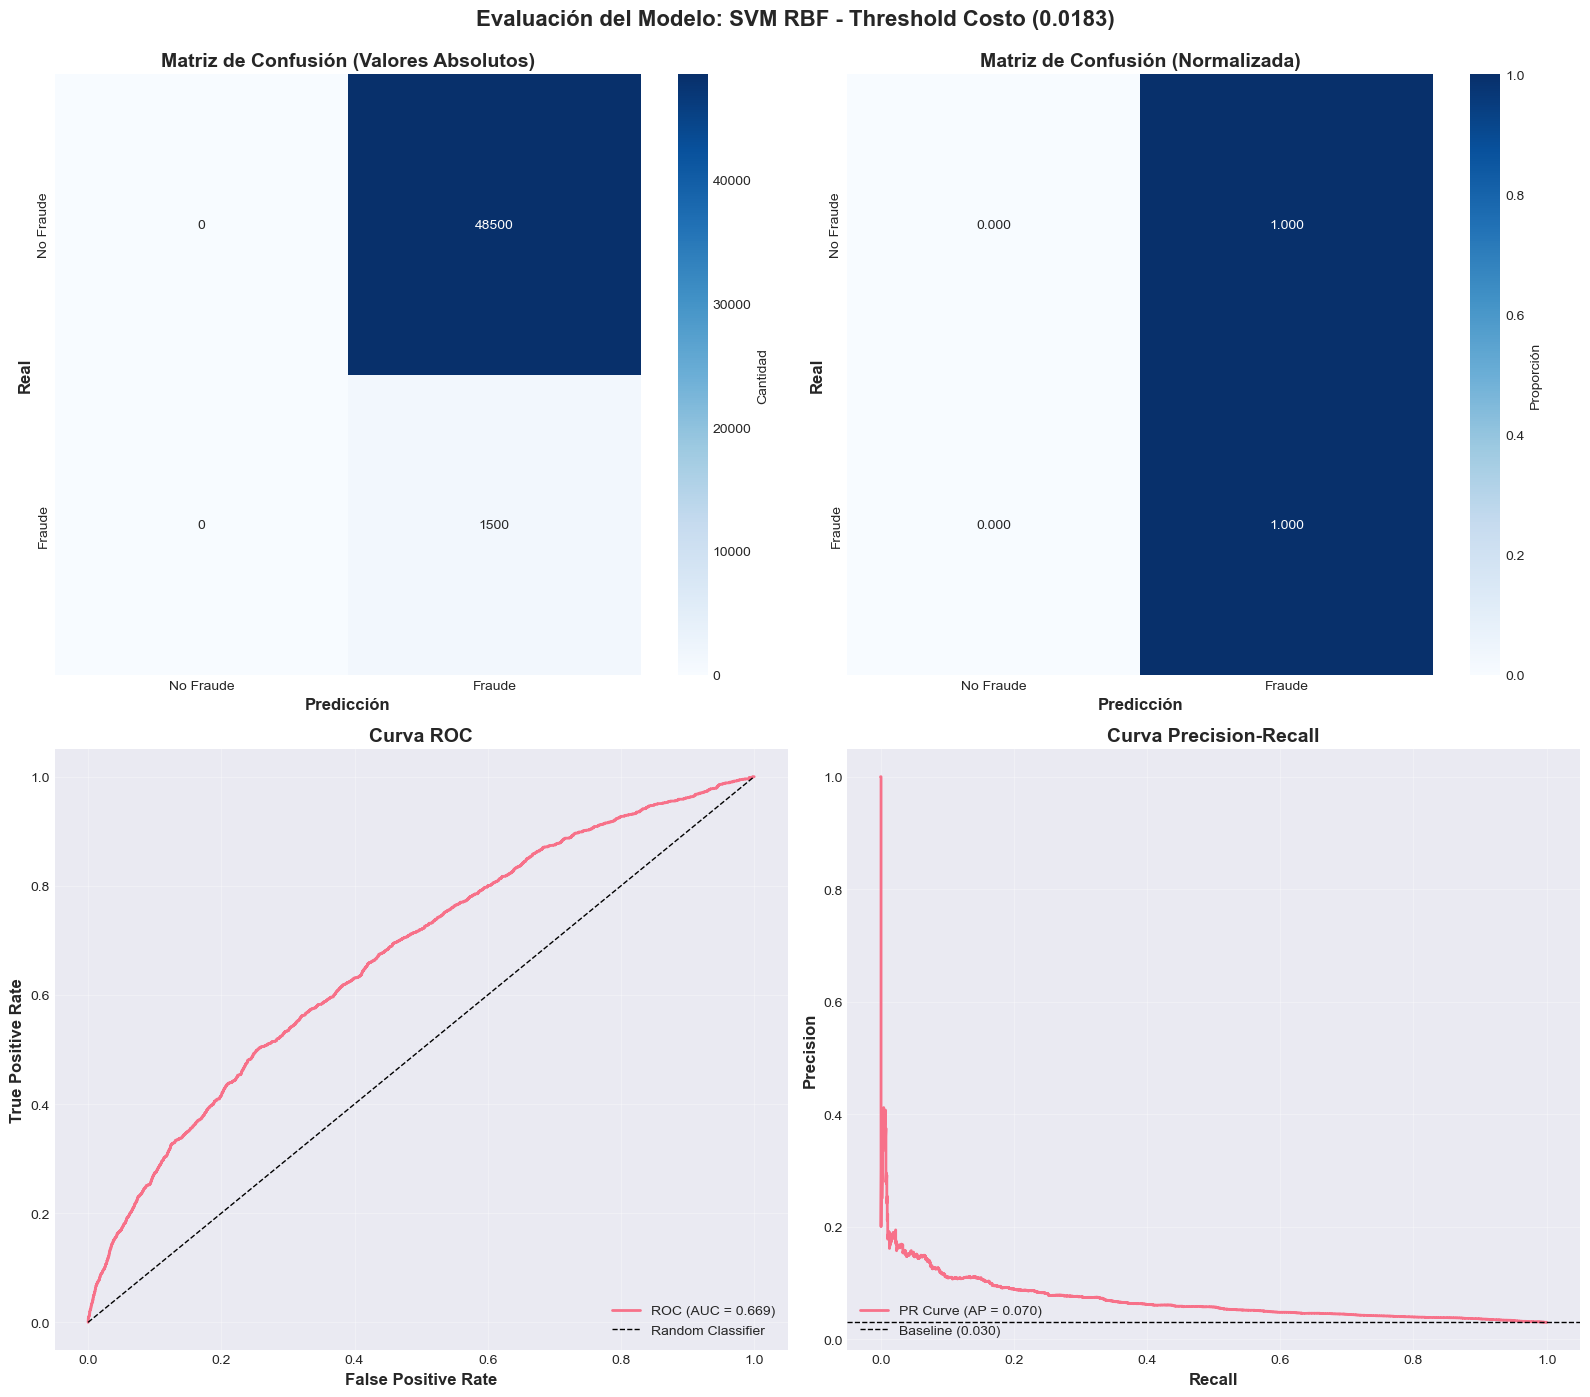

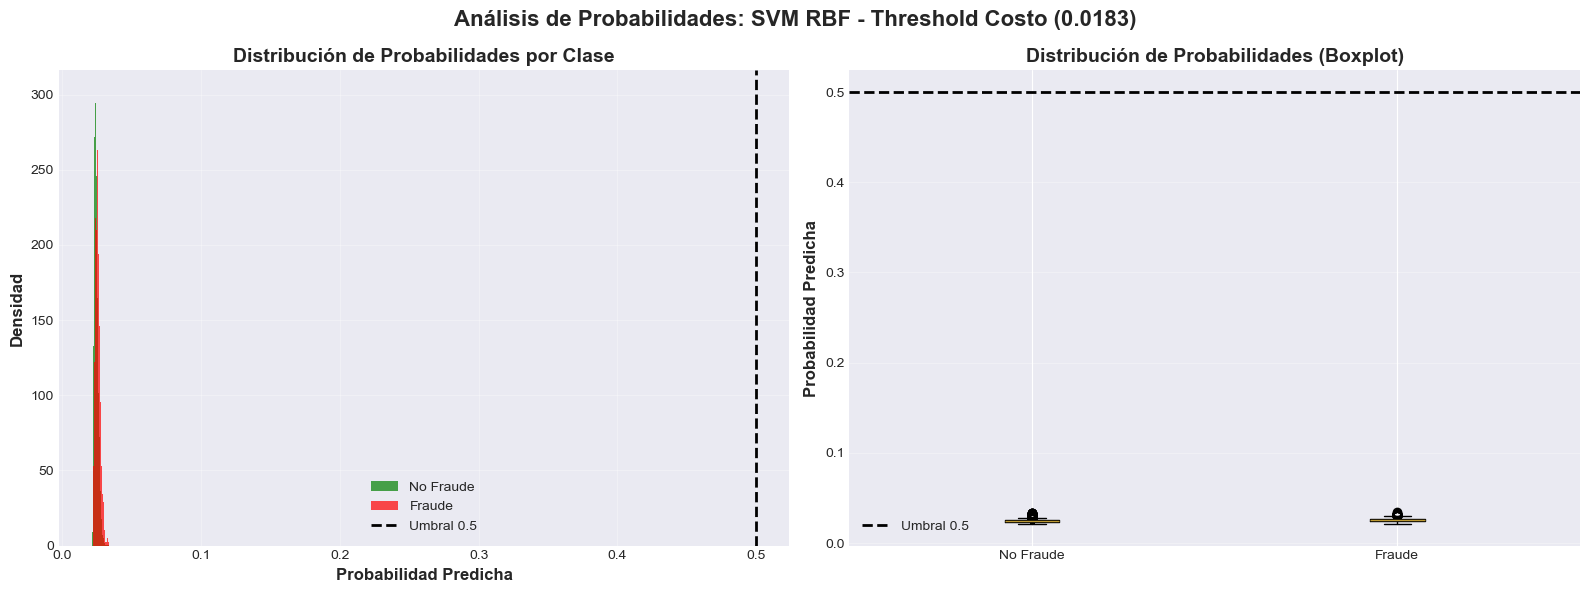


EVALUACIÓN CON THRESHOLD ÓPTIMO (F1 SCORE)
EVALUACIÓN DEL MODELO: SVM RBF - Threshold F1 (0.0174)

📌 Threshold usado: 0.0174

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,500 (97.00%)
   Clase 1 (Fraude):    1,500 (3.00%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.0300
   F1 Score:            0.0583 ⭐
   Precision:           0.0300
   Recall (Sensitivity): 1.0000
   Specificity:         0.0000
   ROC AUC:             0.6693
   Average Precision:   0.0696

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.0000
   Matthews Corr Coef:  0.0000
   NPV:                 0.0000
   False Positive Rate: 1.0000

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.0300
   Recall:             1.0000
   F1 Score:           0.0583
   Cohen's Kappa:      0.0000
   Matthews Corr Coef: 0.0000
   Tasa positivos:     1.0000

💰 COSTO:
   Costo por 1000 registros: 4850.00
   (Costo FP: 5.0, Costo FN: 100.0)

🔢 MATRIZ DE CONFUSIÓN:
                    Predicc

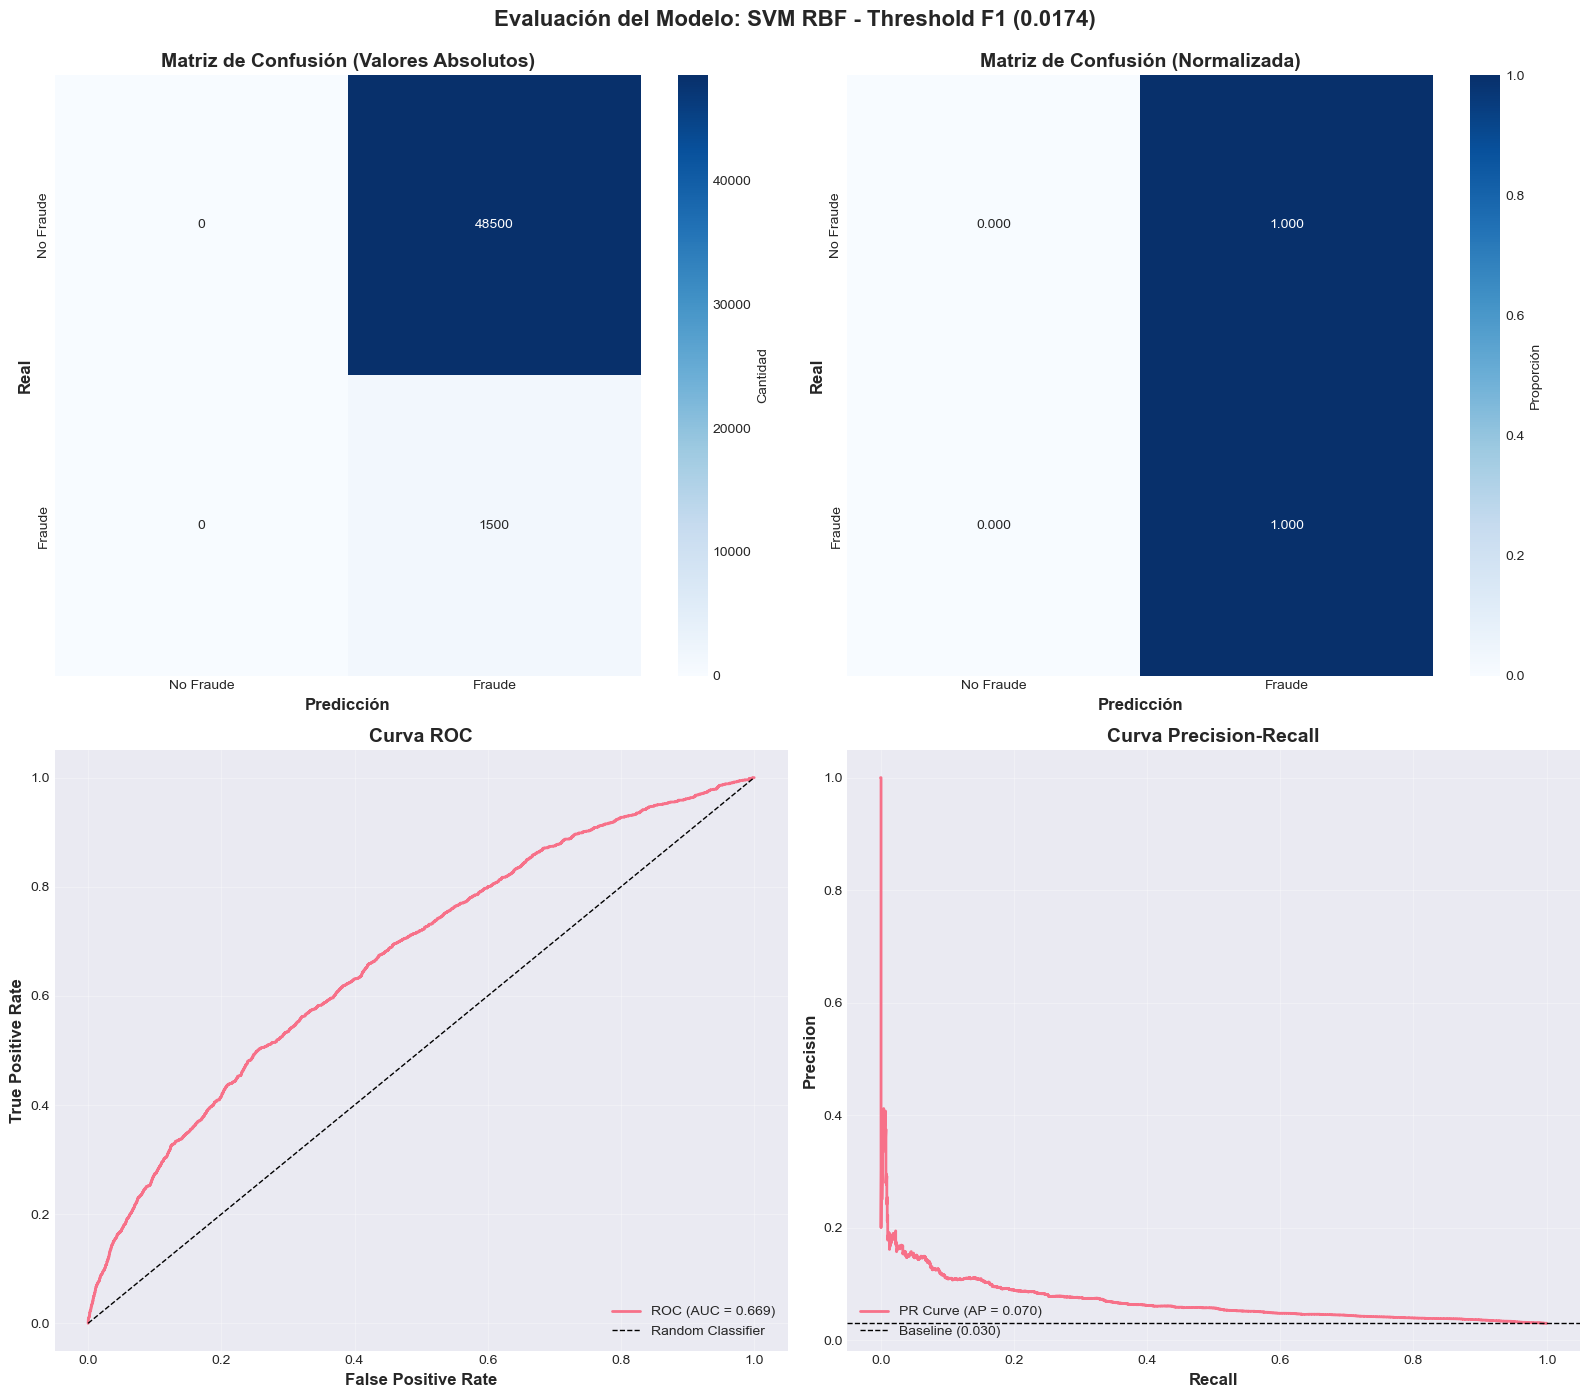

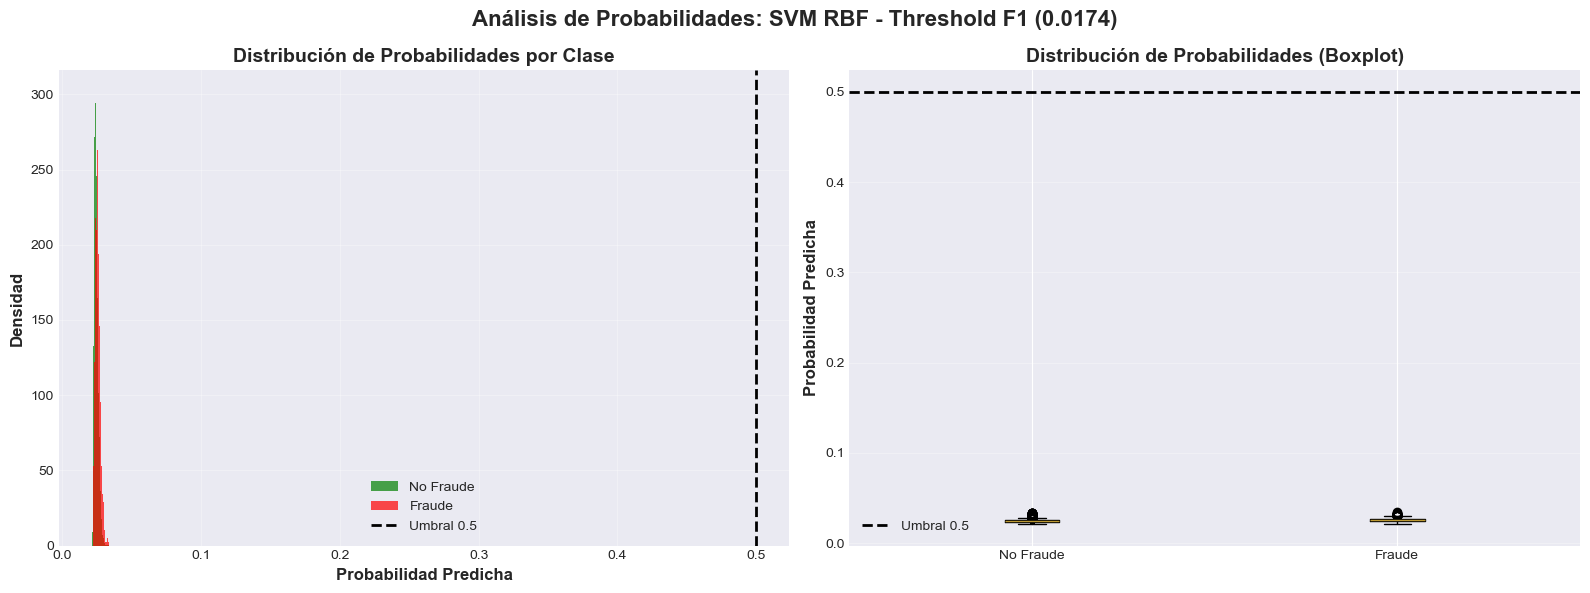

In [11]:
# ============================================================================
# PASO 3: EVALUAR MODELO CON AMBOS THRESHOLDS
# ============================================================================

print("=" * 80)
print("PASO 3: EVALUAR MODELO CON THRESHOLDS ÓPTIMOS")
print("=" * 80)

# Evaluar con threshold óptimo de costo
print("\n" + "=" * 80)
print("EVALUACIÓN CON THRESHOLD ÓPTIMO (COSTO)")
print("=" * 80)

metrics_costo = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_test,
    threshold=threshold_optimo_costo,
    model_name=f"SVM RBF - Threshold Costo ({threshold_optimo_costo:.4f})",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)

# Evaluar con threshold óptimo de F1
print("\n" + "=" * 80)
print("EVALUACIÓN CON THRESHOLD ÓPTIMO (F1 SCORE)")
print("=" * 80)

metrics_f1 = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_test,
    threshold=threshold_optimo_f1,
    model_name=f"SVM RBF - Threshold F1 ({threshold_optimo_f1:.4f})",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)


In [12]:
# ============================================================================
# NOTA SOBRE IMPORTANCIA DE VARIABLES EN SVM RBF
# ============================================================================

print("=" * 80)
print("NOTA SOBRE IMPORTANCIA DE VARIABLES EN SVM RBF")
print("=" * 80)

print("""
⚠️ IMPORTANTE: SVM con kernel RBF no proporciona coeficientes directos como 
   los modelos lineales (Logistic Regression o SVM lineal).

El kernel RBF transforma los datos a un espacio de mayor dimensionalidad donde
no es posible interpretar directamente la importancia de las variables originales.

Para analizar la importancia de variables con SVM RBF, se pueden usar técnicas
alternativas como:
   - Permutation importance
   - SHAP values
   - Feature selection basado en el rendimiento del modelo

En este notebook, nos enfocamos en la evaluación del modelo y la optimización
de thresholds, que son los aspectos más relevantes para el problema de detección
de fraude.
""")

print("\n✅ Análisis de importancia de variables no disponible para SVM RBF")
print("   (El modelo utiliza un kernel no lineal que no permite interpretación directa)")


NOTA SOBRE IMPORTANCIA DE VARIABLES EN SVM RBF

⚠️ IMPORTANTE: SVM con kernel RBF no proporciona coeficientes directos como 
   los modelos lineales (Logistic Regression o SVM lineal).

El kernel RBF transforma los datos a un espacio de mayor dimensionalidad donde
no es posible interpretar directamente la importancia de las variables originales.

Para analizar la importancia de variables con SVM RBF, se pueden usar técnicas
alternativas como:
   - Permutation importance
   - SHAP values
   - Feature selection basado en el rendimiento del modelo

En este notebook, nos enfocamos en la evaluación del modelo y la optimización
de thresholds, que son los aspectos más relevantes para el problema de detección
de fraude.


✅ Análisis de importancia de variables no disponible para SVM RBF
   (El modelo utiliza un kernel no lineal que no permite interpretación directa)
